In [1]:
# Adapted from https://jrtechs.net/photography/segmenting-images-with-quadtrees

import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import random
import math
import numpy as np

In [2]:
# Taken from https://www.flickr.com/photos/exfordy/2050743941
img = cv2.imread("img/fabric_test_1_small.jpg")

In [225]:
def printI(img, size=20):
    fig= plt.figure(figsize=(size, size))
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    
def printI2(i1, i2):
    fig= plt.figure(figsize=(20, 10))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(cv2.cvtColor(i1, cv2.COLOR_BGR2RGB))
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(cv2.cvtColor(i2, cv2.COLOR_BGR2RGB))

In [4]:
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

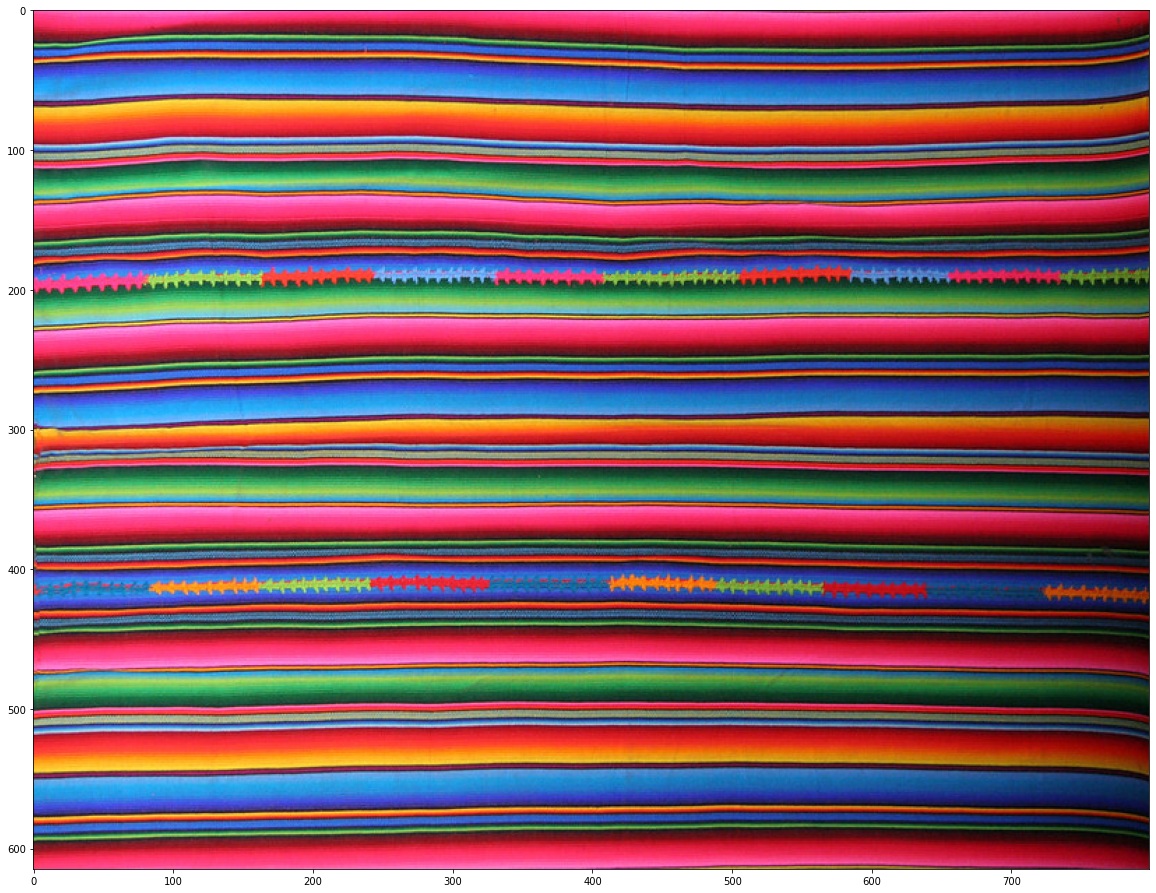

In [5]:
printI(img)

In [6]:
class Node():
    def __init__(self, x0, y0, w, h):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.children = []

    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points
    
    def get_points(self, img):
        return img[self.x0:self.x0 + self.get_width(), self.y0:self.y0+self.get_height()]
    
    def get_error(self, img):
        pixels = self.get_points(img)
        b_avg = np.mean(pixels[:,:,0])
        b_mse = np.square(np.subtract(pixels[:,:,0], b_avg)).mean()
    
        g_avg = np.mean(pixels[:,:,1])
        g_mse = np.square(np.subtract(pixels[:,:,1], g_avg)).mean()
        
        r_avg = np.mean(pixels[:,:,2])
        r_mse = np.square(np.subtract(pixels[:,:,2], r_avg)).mean()
        
        e = r_mse * 0.2989 + g_mse * 0.5870 + b_mse * 0.1140
        
        return (e * img.shape[0]* img.shape[1])/90000000

In [222]:
class QTree():
    def __init__(self, stdThreshold, minPixelSize, img):
        self.threshold = stdThreshold
        self.min_size = minPixelSize
        self.minPixelSize = minPixelSize
        self.img = img
        self.root = Node(0, 0, img.shape[0], img.shape[1])

    def get_points(self):
        return img[self.root.x0:self.root.x0 + self.root.get_width(), self.root.y0:self.root.y0+self.root.get_height()]
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold, self.minPixelSize, self.img)
    
    def graph_tree(self):
        fig = plt.figure(figsize=(10, 10))
        plt.title("Quadtree")
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        for n in c:
            plt.gcf().gca().add_patch(patches.Rectangle((n.y0, n.x0), n.height, n.width, fill=False))
        plt.gcf().gca().set_xlim(0,img.shape[1])
        plt.gcf().gca().set_ylim(img.shape[0], 0)
        plt.axis('equal')
        plt.show()
        return

    def render_img(self, thickness = 1, color = (0,0,0), outlineLevel=None):
        imgc = self.img.copy()
        c = find_children_with_level(self.root)
        for (_, n) in c:
            pixels = n.get_points(self.img)
            # grb
            gAvg = math.floor(np.mean(pixels[:,:,0]))
            rAvg = math.floor(np.mean(pixels[:,:,1]))
            bAvg = math.floor(np.mean(pixels[:,:,2]))

            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 0] = gAvg
            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 1] = rAvg
            imgc[n.x0:n.x0 + n.get_width(), n.y0:n.y0+n.get_height(), 2] = bAvg

        if thickness > 0:
            for (l, n) in c:
                # Draw a rectangle
                if l == outlineLevel or not outlineLevel:
                    imgc = cv2.rectangle(imgc, (n.y0, n.x0), (n.y0+n.get_height(), n.x0+n.get_width()), color, thickness)
        return imgc

In [214]:
def recursive_subdivide(node, k, minPixelSize, img):

    if node.get_error(img)<=k:
        return
    w_1 = int(math.floor(node.width/2))
    w_2 = int(math.ceil(node.width/2))
    h_1 = int(math.floor(node.height/2))
    h_2 = int(math.ceil(node.height/2))


    if w_1 <= minPixelSize or h_1 <= minPixelSize:
        return
    x1 = Node(node.x0, node.y0, w_1, h_1) # top left
    recursive_subdivide(x1, k, minPixelSize, img)

    x2 = Node(node.x0, node.y0+h_1, w_1, h_2) # btm left
    recursive_subdivide(x2, k, minPixelSize, img)

    x3 = Node(node.x0 + w_1, node.y0, w_2, h_1)# top right
    recursive_subdivide(x3, k, minPixelSize, img)

    x4 = Node(node.x0+w_1, node.y0+h_1, w_2, h_2) # btm right
    recursive_subdivide(x4, k, minPixelSize, img)

    node.children = [x1, x3, x2, x4]
   

def find_children(node):
   if not node.children:
       return [node]
   else:
       children = []
       for child in node.children:
           children += (find_children(child))
   return children

Number of segments: 11431


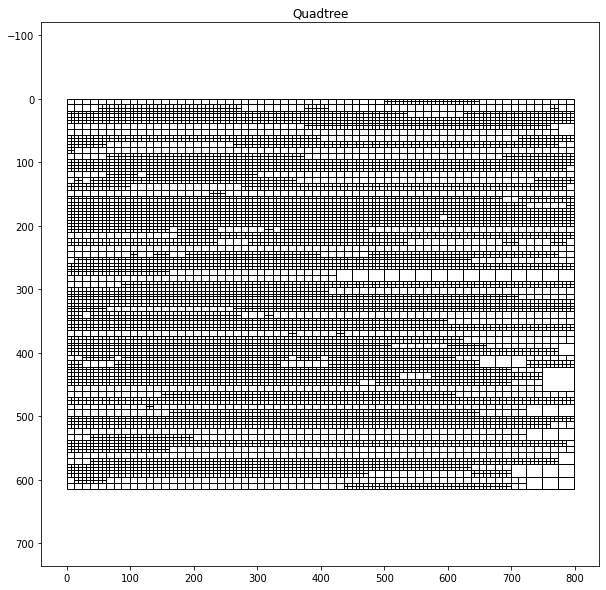

Number of segments: 3163


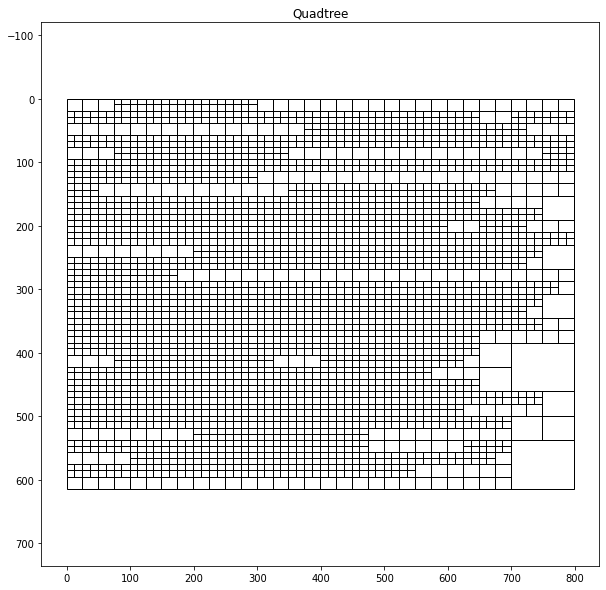

In [9]:
qtTemp = QTree(4, 3, img)  #contrast threshold, min cell size, img
qtTemp.subdivide() # recursively generates quad tree
qtTemp.graph_tree()

qtTemp2 = QTree(9, 5, img) 
qtTemp2.subdivide()
qtTemp2.graph_tree()

In [10]:
def concat_images(img1, img2, border=5, color=(255,255,255)):
    img1_border = cv2.copyMakeBorder(
                 img1, 
                 border, #top
                 border, #btn
                 border, #left
                 border, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    img2_border = cv2.copyMakeBorder(
                 img2, 
                 border, #top
                 border, #btn
                 0, #left
                 border, #right
                 cv2.BORDER_CONSTANT, 
                 value=color
              )
    return np.concatenate((img1_border, img2_border), axis=1)

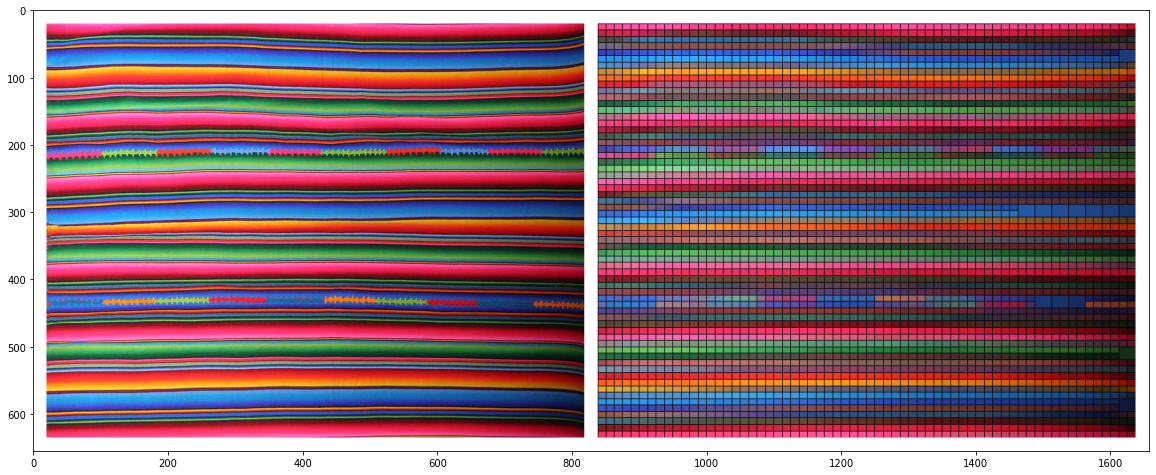

In [11]:
def displayQuadTree(img_name, threshold=7, minCell=3, img_border=20, line_border=1, line_color=(0,0,0), rotate=False):
    imgT= cv2.imread(img_name)
    if rotate:
        imgT = cv2.rotate(imgT, cv2.ROTATE_90_CLOCKWISE)
    qt = QTree(threshold, minCell, imgT) 
    qt.subdivide()
    qtImg= qt.render_img(thickness=line_border, color=line_color)
    file_name = "output/" + img_name.split("/")[-1]
    cv2.imwrite(file_name,qtImg)
    file_name_2 = "output/diptych-" + img_name[-6] + img_name[-5] + ".jpg"
    hConcat = concat_images(imgT, qtImg, border=img_border, color=(255,255,255))
    cv2.imwrite(file_name_2,hConcat)
    printI(hConcat)

displayQuadTree("img/fabric_test_1_small.jpg", threshold=2, minCell=5, rotate=True)

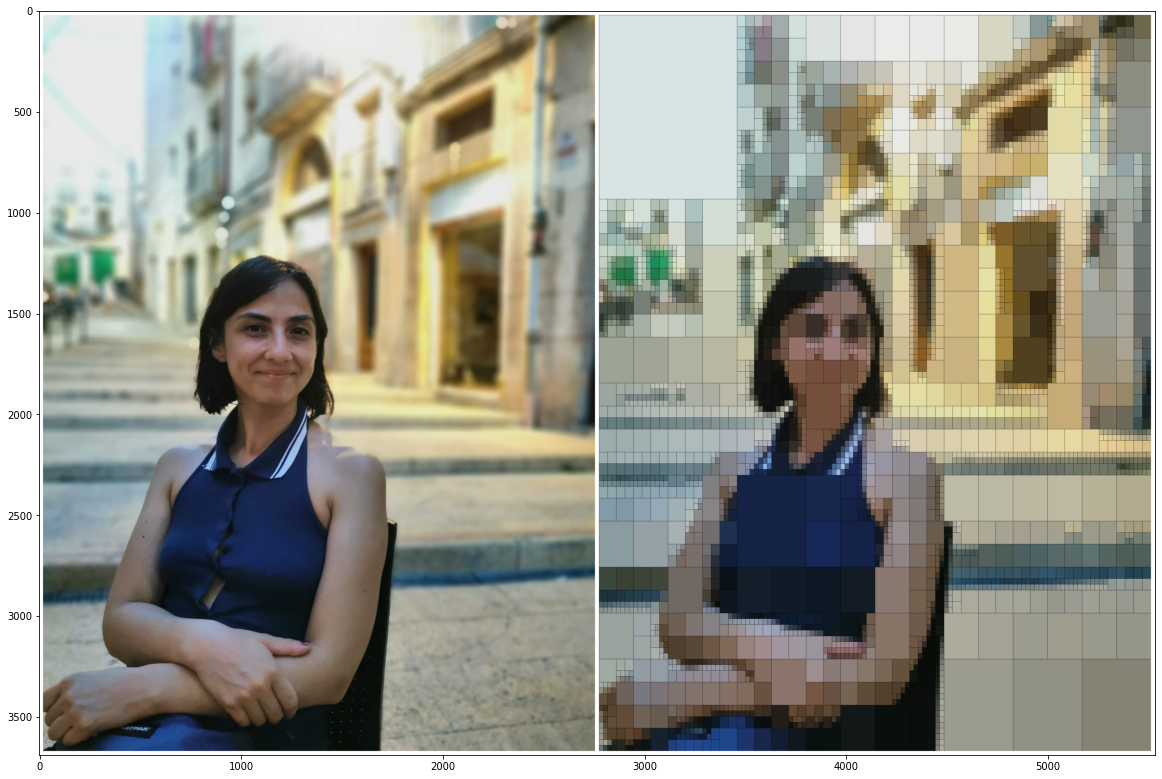

In [12]:
displayQuadTree("img/coti.jpg", threshold=50, minCell=20)

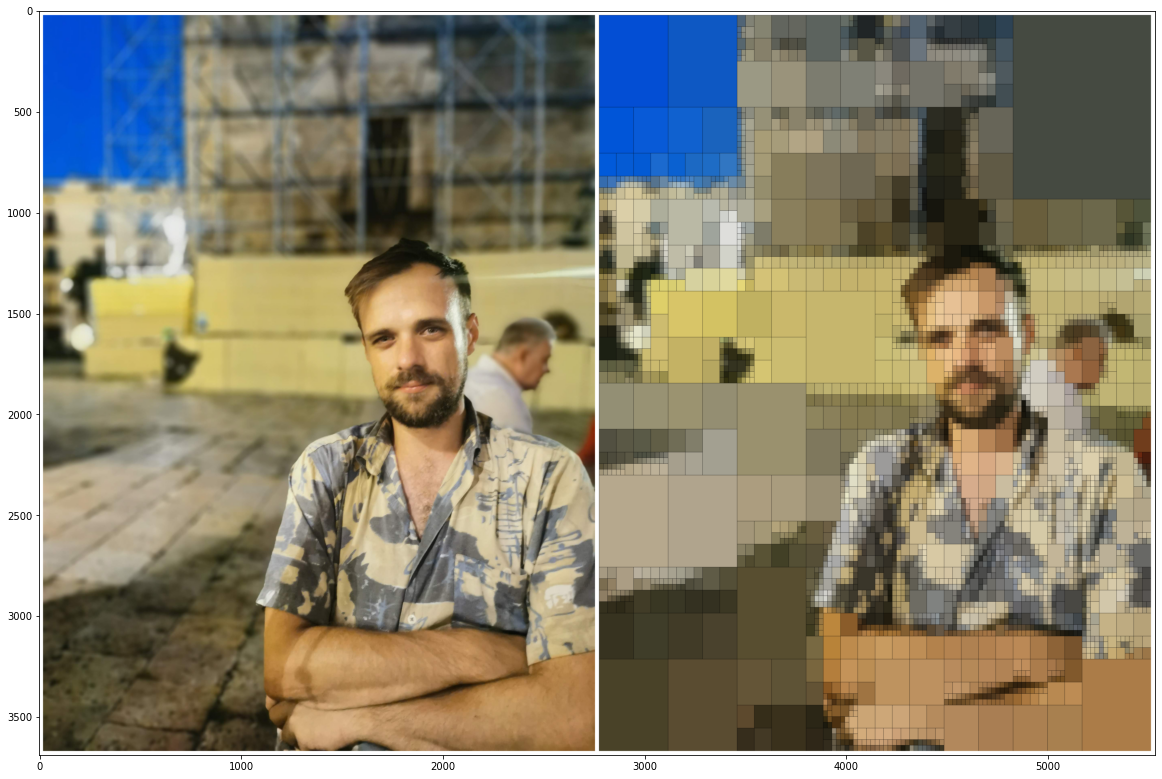

In [13]:
displayQuadTree("img/tim.jpg", threshold=50, minCell=20)

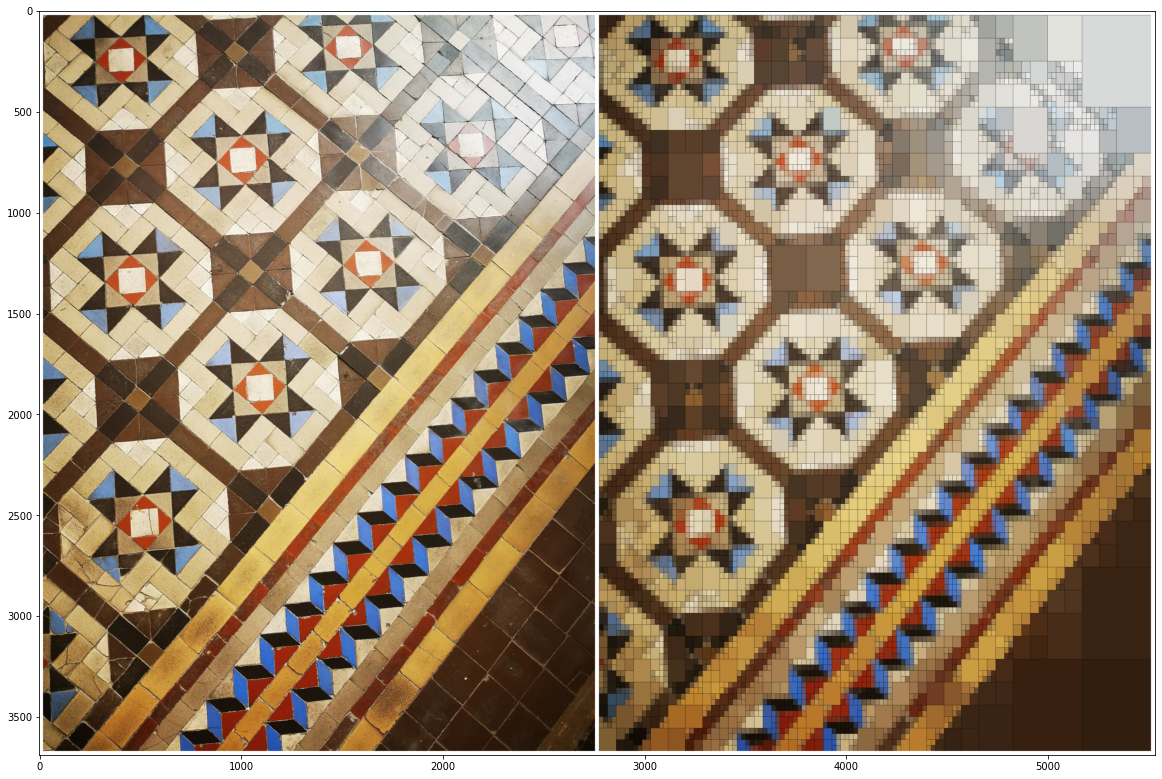

In [219]:
displayQuadTree("img/tarragona_floor.jpg", threshold=100, minCell=20)

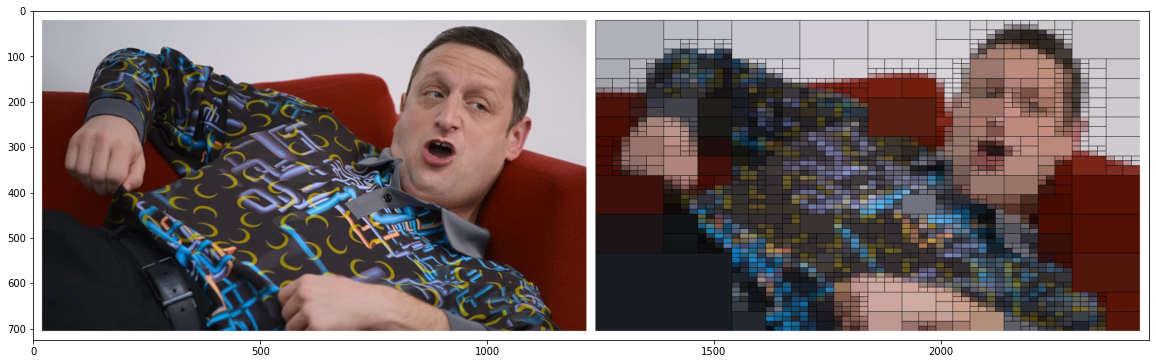

In [218]:
displayQuadTree("img/dan_flashes.jpg", threshold=5, minCell=5)

In [31]:
# Fuck it, we'll do it LIVE!
# Adapted from https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1
cap = cv2.VideoCapture(0)
cap.set(3,640) # adjust width
cap.set(4,480) # adjust height


def displayQuadTreeForImg(imgT, threshold=7, minCell=3, img_border=20, line_border=1, line_color=(0,0,0)):
    qt = QTree(threshold, minCell, imgT) 
    qt.subdivide()
    qtImg= qt.render_img(thickness=line_border, color=line_color)
    hConcat = concat_images(imgT, qtImg, border=img_border, color=(255,255,255))
    return hConcat

while True:
    success, img = cap.read()
    tree = displayQuadTreeForImg(img, threshold=5, minCell=5)
    cv2.imshow("Webcam", tree) # This will open an independent window
    if cv2.waitKey(1) & 0xFF==ord('q'): # quit when 'q' is pressed
        cap.release()
        break
        
cv2.destroyAllWindows() 
cv2.waitKey(1) # normally unnecessary, but it fixes a bug on MacOS where the window do

-1

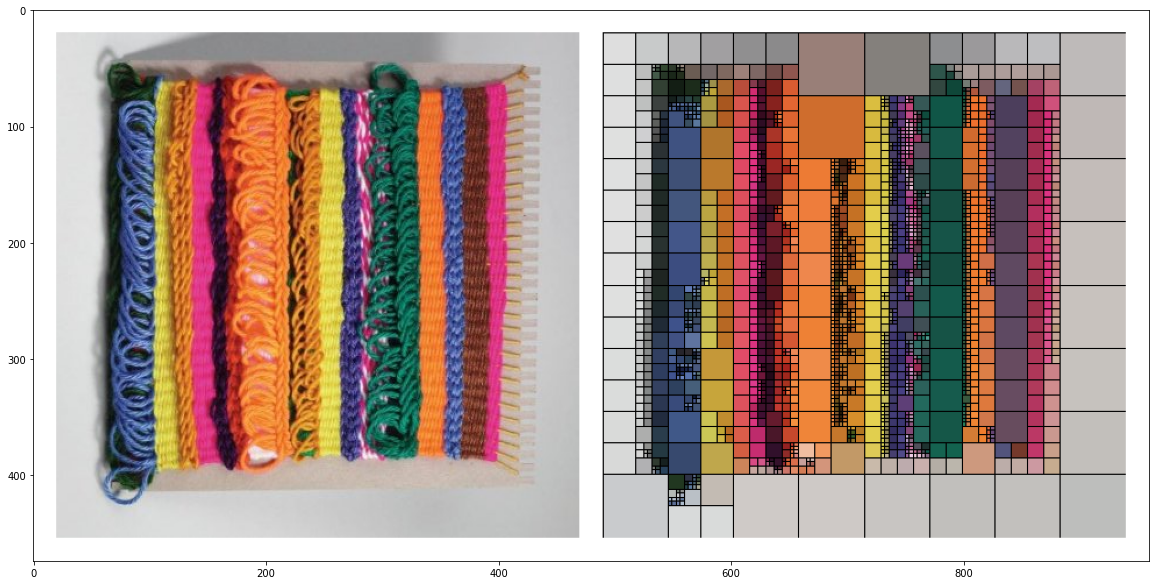

In [172]:
displayQuadTree("img/weave.jpg", threshold=3, minCell=2, rotate=True)

In [173]:
imgT= cv2.imread("img/weave.jpg")
imgT = cv2.rotate(imgT, cv2.ROTATE_90_CLOCKWISE)
qt = QTree(3, 2, imgT) 
qt.subdivide()

Number of segments: 1924


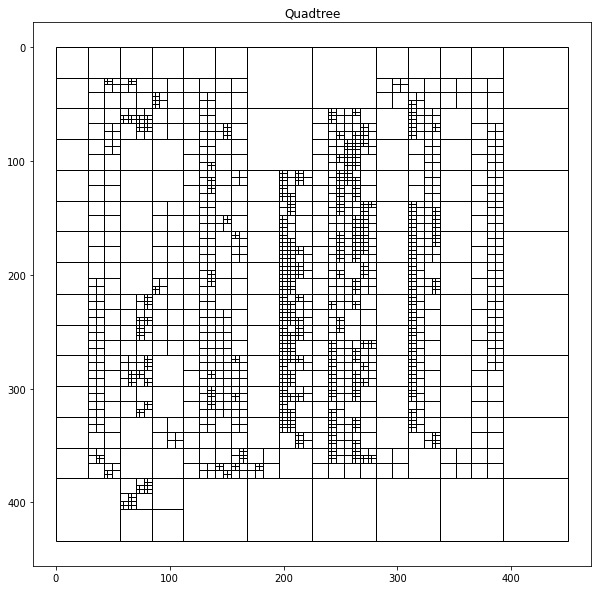

In [174]:
qt.graph_tree()

In [175]:
[ (n.width, n.height) for n in qt.root.children]

[(217, 225), (217, 225), (217, 225), (217, 225)]

In [176]:
max(n.height for n in find_children(qt.root) if len(n.children) == 0)

57

In [177]:
def find_children_with_level(node, level=0):
   if not node.children:
       return [(level, node)]
   else:
       children = []
       for child in node.children:
           children += (find_children_with_level(child, level+1))
       return children

In [178]:
import operator
def level_for_max_prop(qt, prop):
    getProp = operator.attrgetter(prop)
    return max(((l, getProp(n)) for (l, n) in find_children_with_level(qt.root) if len(n.children) == 0), key=lambda p: p[1])[0]

In [179]:
level_for_max_prop(qt, "width")

3

In [180]:
def tree_to_sequence(qt):
    level = level_for_max_prop(qt, "height")
    nodes = []

In [181]:
from functools import reduce
flat_map = lambda f, xs: reduce(lambda a, b: a + b, map(f, xs))


In [182]:
def get_level(level, node, current_level=1):
    if level == 0:
        return [node] 
    elif level == current_level:
        return node.children
    else:
        return flat_map(lambda c: get_level(level, c, current_level+1), node.children)

In [183]:
len(get_level(3, qt.root))

64

In [203]:
class SeqNode:
    def __init__(self, root, seq):
        self.seq = seq
        self.root = root
        
        
    def get_width(self):
        return self.root.get_width()
    
    def get_height(self):
        return self.root.get_height()
    
    def render_img(self, thickness = 1, color = (0, 0, 0)):
        imgc = np.zeros((self.root.height, self.root.width, 3), np.uint8)
        c = find_children(self.root)
        for n in c:
            pixels = n.get_points(self.seq.img)
            # grb
            gAvg = math.floor(np.mean(pixels[:,:,0]))
            rAvg = math.floor(np.mean(pixels[:,:,1]))
            bAvg = math.floor(np.mean(pixels[:,:,2]))
            
            nX = n.x0 - self.root.x0
            nY = n.y0 - self.root.y0

            imgc[nY:nY + n.get_height(), nX:nX+n.get_width(), 0] = gAvg
            imgc[nY:nY + n.get_height(), nX:nX+n.get_width(), 1] = rAvg
            imgc[nY:nY + n.get_height(), nX:nX+n.get_width(), 2] = bAvg

        if thickness > 0:
            for n in c:
                nX = n.x0 - self.root.x0
                nY = n.y0 - self.root.y0
                # Draw a rectangle
                imgc = cv2.rectangle(imgc, (nY, nX), (nY+n.get_height(), nX+n.get_width()), color, thickness)
        return imgc

class Sequence:
    def __init__(self, tree):
        level = level_for_max_prop(tree, "height")
        self.nodes = [SeqNode(node, self) for node in get_level(level, tree.root)];
        self.img = tree.img
        self.width = sum([node.get_width() for node in self.nodes])
        self.height = max([node.get_height() for node in self.nodes])
    
    def render_img(self, thickness = 1, color = (0,0,0)):
        imgc = blank_image = np.zeros((self.height,self.width,3), np.uint8)
        left = 0
        for n in self.nodes:
            imgc[0:n.get_height(),left:left + n.get_width(), 0:3] = n.render_img()
            left = left + n.get_width()

        if thickness > 0:
            left = 0
            for n in self.nodes:
                # Draw a rectangle
                imgc = cv2.rectangle(imgc, (0, left), (n.get_height(), n.get_width()), color, thickness)
                left = left + n.get_width()
        return imgc
        
        

In [185]:
s = Sequence(qt)

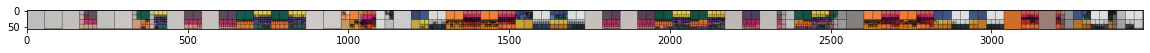

In [186]:
printI(cv2.rotate(s.render_img(), cv2.ROTATE_90_CLOCKWISE))

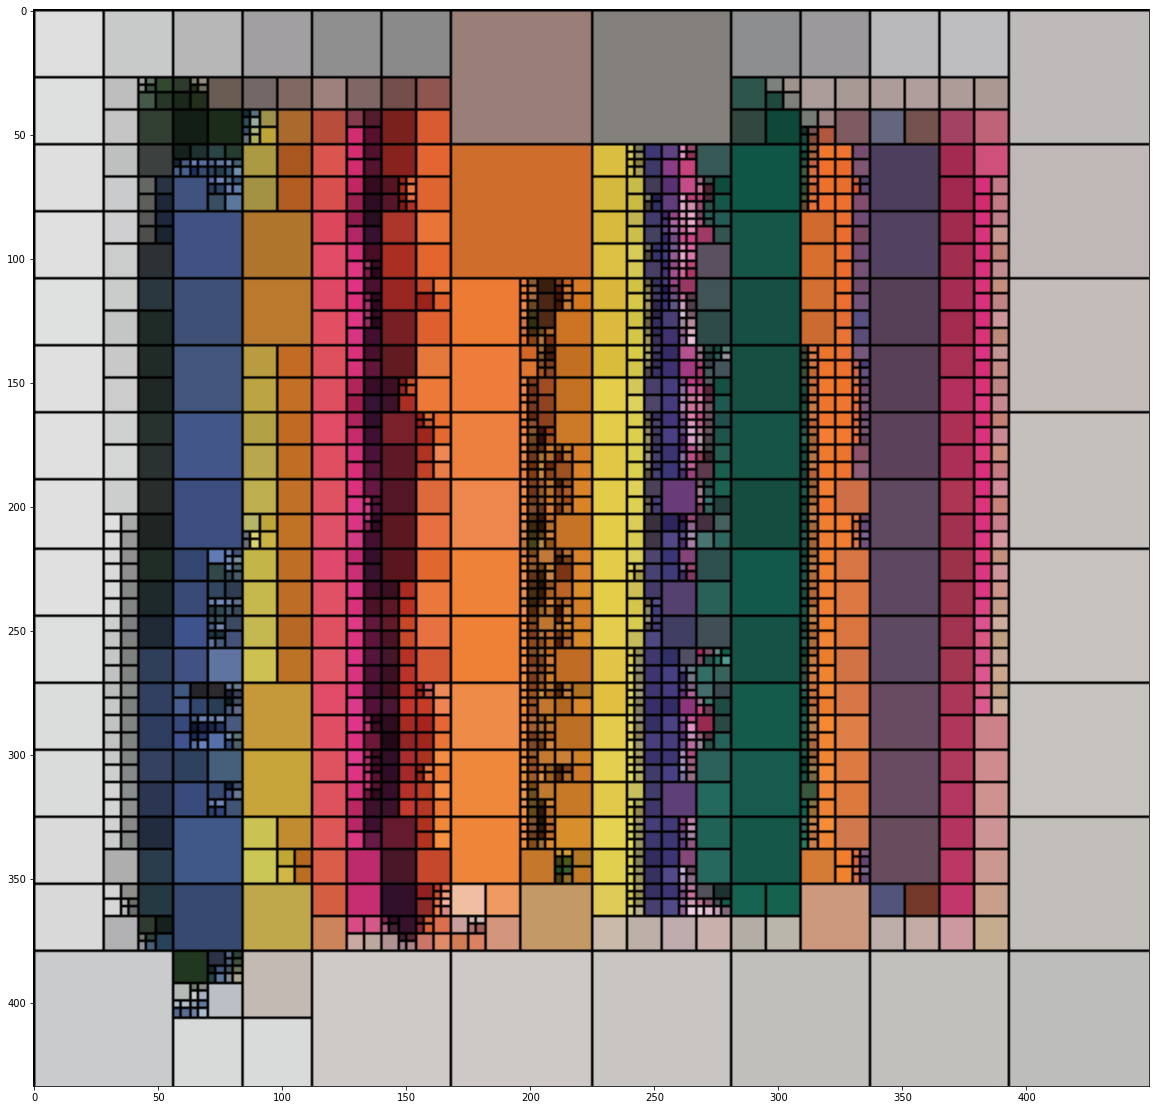

In [187]:
printI(qt.render_img())

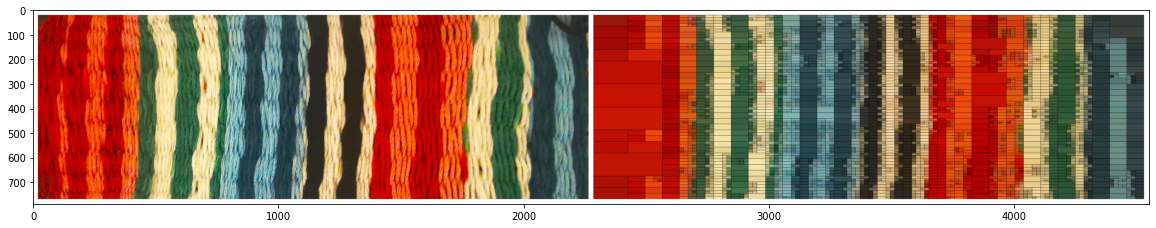

In [193]:
displayQuadTree("img/weave_1.jpg", threshold=20, minCell=5)

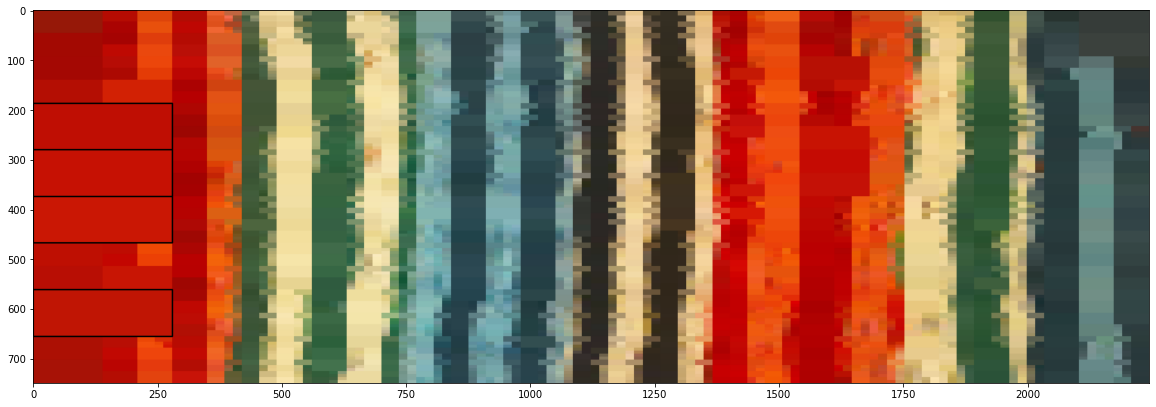

In [224]:
from scipy import ndimage
imgT= cv2.imread("img/weave_1.jpg")
#imgT = ndimage.rotate(imgT, 5)
qt = QTree(20, 5, imgT) 
qt.subdivide()
printI(qt.render_img(outlineLevel=3, thickness=2))

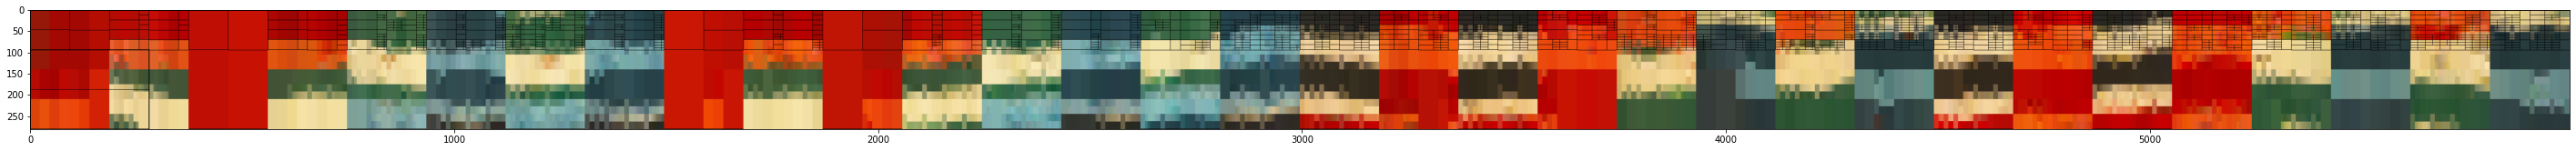

In [234]:
s = Sequence(qt)
printI(s.render_img(), size=50)

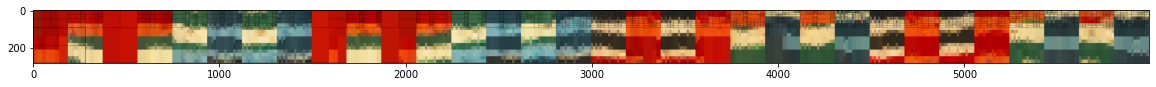

In [217]:
printI(s.render_img(our))

In [213]:
level_for_max_prop(qt, "height")

3